In [1]:
import pandas as pd
import os
from pathlib import Path

In [2]:
DATADIR = "./2023_0511"
data = Path(DATADIR)

### Retrieve power consumption and failed pods data from the experiments

In [3]:
df_pwr_dict = {}
df_sched_pod_dict = {}

fileDirs = sorted([x for x in data.iterdir() if x.is_dir()])
for fdir in fileDirs:
    policyDirs = sorted([x for x in fdir.iterdir() if x.is_dir()])
    for pdir in policyDirs:            
        tuneDirs = sorted([x for x in pdir.iterdir() if x.is_dir()])
        for tdir in tuneDirs:
            seedDirs = sorted([x for x in tdir.iterdir() if x.is_dir()])
            for sdir in seedDirs:
                pwrfile = sdir / 'analysis_pwr.csv'
                schedfile = sdir / 'analysis_cdol.csv'
                
                try:
                    df_pwr_dict[pdir.name] = pd.read_csv(pwrfile).loc[1:].reset_index(drop = True)
                    df_pwr_dict[pdir.name].rename(columns = lambda x: x.split('-')[-1], inplace=True)

                except Exception as e:
                    exit("ERROR: file %s\n%s" % (pwrfile, e))

                try:
                    df_sched_pod_dict[pdir.name] = pd.read_csv(schedfile)
                    df_sched_pod_dict[pdir.name].rename(columns = lambda x: x.split('-')[-1], inplace=True)
                    df_sched_pod_dict[pdir.name]['event'] = 1 * (df_sched_pod_dict[pdir.name]['event'] == 'failed')
                    df_sched_pod_dict[pdir.name]['event'] = df_sched_pod_dict[pdir.name]['event'].cumsum()

                except Exception as e:
                    exit("ERROR: file %s\n%s" % (schedfile, e))

### Analysis overall cluster power consumption: $FGD$ vs $PWR$ vs $0.5 \cdot FGD + 0.5 \cdot PWR$

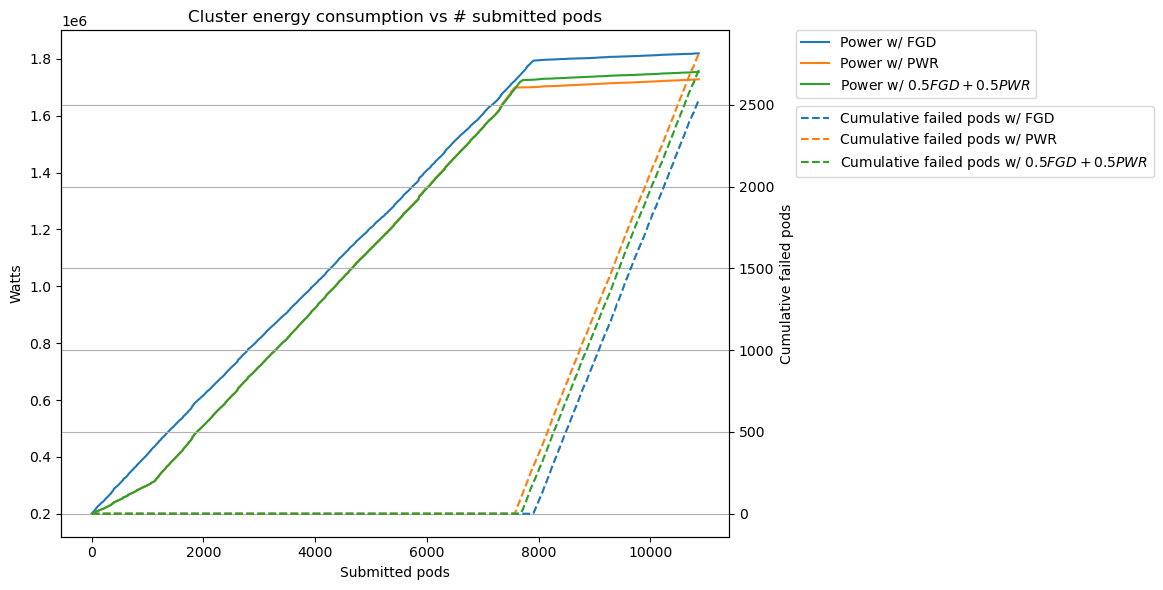

In [4]:
import matplotlib.pyplot as plt

df_fgd = df_pwr_dict['06-FGD']
df_pwr = df_pwr_dict['07-PWR']
df_mix = df_pwr_dict['08-MIX']

df_fgd_failed = df_sched_pod_dict['06-FGD']
df_pwr_failed = df_sched_pod_dict['07-PWR']
df_mix_failed = df_sched_pod_dict['08-MIX']

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_fgd.index, df_fgd['power_cluster'], label='Power w/ FGD')
ax1.plot(df_pwr.index, df_pwr['power_cluster'], label='Power w/ PWR')
ax1.plot(df_mix.index, df_mix['power_cluster'], label='Power w/ $0.5FGD + 0.5PWR$')
ax1.set_xlabel('Submitted pods')
ax1.set_ylabel('Watts')

ax2 = ax1.twinx()
ax2.plot(df_fgd_failed.index, df_fgd_failed["event"], label="Cumulative failed pods w/ FGD", linestyle='dashed')
ax2.plot(df_fgd_failed.index, df_pwr_failed["event"], label="Cumulative failed pods w/ PWR", linestyle='dashed')
ax2.plot(df_fgd_failed.index, df_mix_failed["event"], label="Cumulative failed pods w/ $0.5FGD + 0.5PWR$", linestyle='dashed')
ax2.set_ylabel("Cumulative failed pods")
ax2.tick_params(axis='y')

# Legends
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1), borderaxespad=0.)
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.85), borderaxespad=0.)

plt.title('Cluster energy consumption vs # submitted pods')
plt.grid(True)
plt.tight_layout()
plt.show()

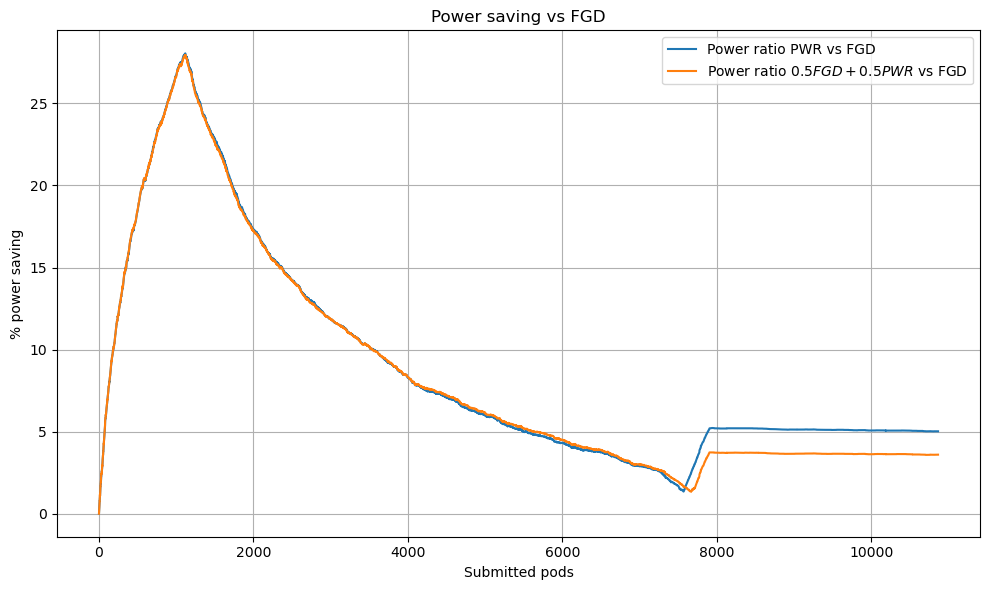

In [5]:
df_fgd = df_pwr_dict['06-FGD']
df_pwr = df_pwr_dict['07-PWR']
df_mix = df_pwr_dict['08-MIX']

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(df_pwr.index, (df_fgd['power_cluster'] - df_pwr['power_cluster']) / df_fgd['power_cluster'] * 100, label='Power ratio PWR vs FGD')
ax1.plot(df_mix.index, (df_fgd['power_cluster'] - df_mix['power_cluster']) / df_fgd['power_cluster'] * 100, label='Power ratio $0.5FGD + 0.5PWR$ vs FGD')
ax1.set_xlabel('Submitted pods')
ax1.set_ylabel('% power saving')

# Legends
ax1.legend(loc='upper right')

plt.title('Power saving vs FGD')
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis GPU cluster power consumption: $FGD$ vs $PWR$ vs $0.5 \cdot FGD + 0.5 \cdot PWR$

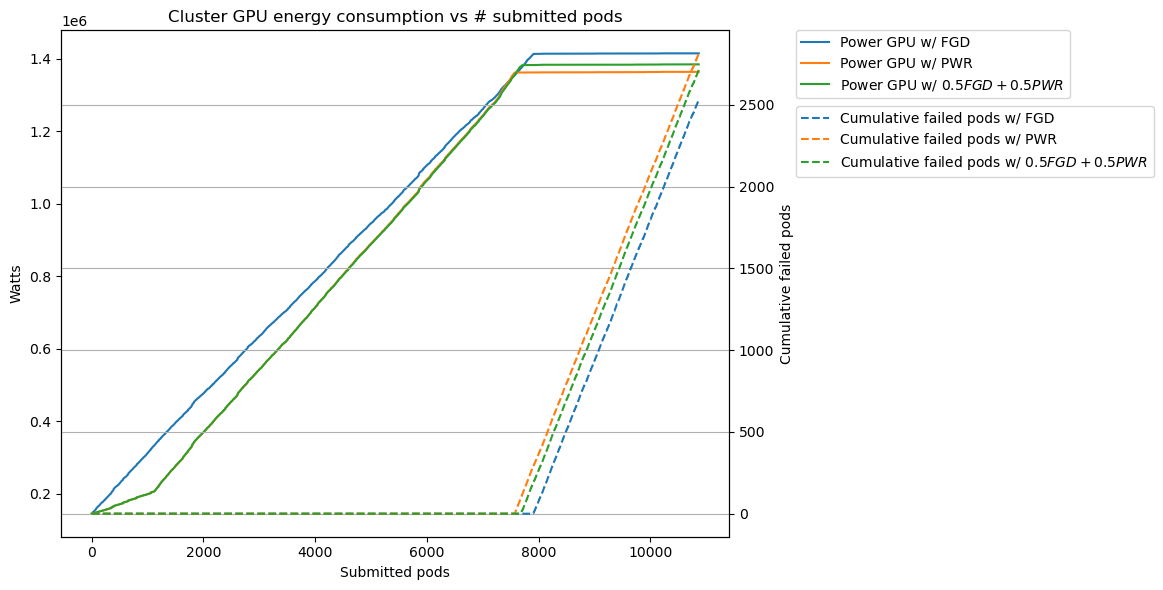

In [6]:
df_fgd = df_pwr_dict['06-FGD']
df_pwr = df_pwr_dict['07-PWR']
df_mix = df_pwr_dict['08-MIX']

df_fgd_failed = df_sched_pod_dict['06-FGD']
df_pwr_failed = df_sched_pod_dict['07-PWR']
df_mix_failed = df_sched_pod_dict['08-MIX']

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_fgd.index, df_fgd['power_cluster_GPU'], label='Power GPU w/ FGD')
ax1.plot(df_pwr.index, df_pwr['power_cluster_GPU'], label='Power GPU w/ PWR')
ax1.plot(df_mix.index, df_mix['power_cluster_GPU'], label='Power GPU w/ $0.5FGD + 0.5PWR$')
ax1.set_xlabel('Submitted pods')
ax1.set_ylabel('Watts')

ax2 = ax1.twinx()
ax2.plot(df_fgd_failed.index, df_fgd_failed["event"], label="Cumulative failed pods w/ FGD", linestyle='dashed')
ax2.plot(df_fgd_failed.index, df_pwr_failed["event"], label="Cumulative failed pods w/ PWR", linestyle='dashed')
ax2.plot(df_fgd_failed.index, df_mix_failed["event"], label="Cumulative failed pods w/ $0.5FGD + 0.5PWR$", linestyle='dashed')
ax2.set_ylabel("Cumulative failed pods")
ax2.tick_params(axis='y')

# Legends
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1), borderaxespad=0.)
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.85), borderaxespad=0.)

plt.title('Cluster GPU energy consumption vs # submitted pods')
plt.grid(True)
plt.tight_layout()
plt.show()

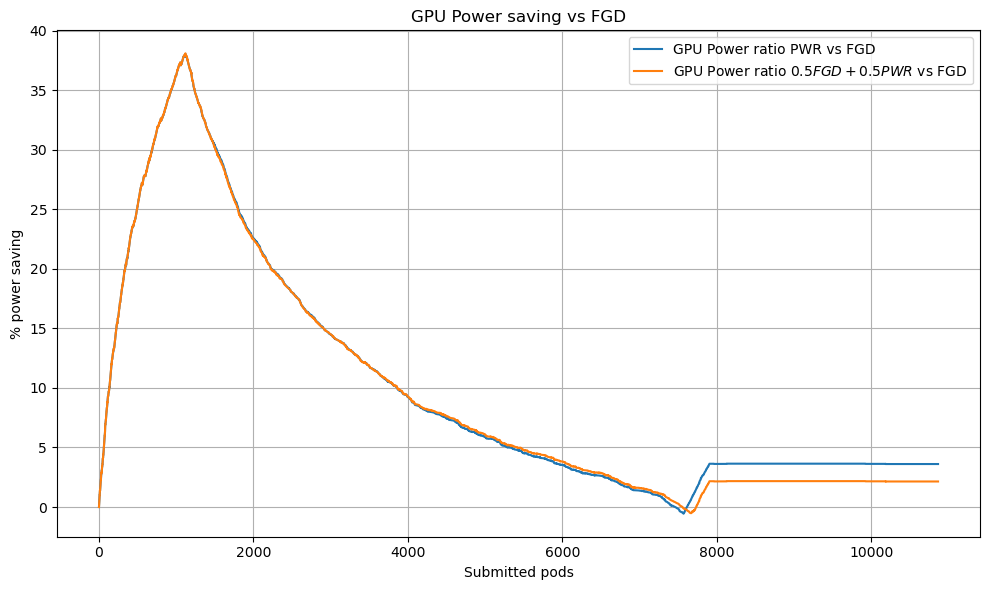

In [7]:
df_fgd = df_pwr_dict['06-FGD']
df_pwr = df_pwr_dict['07-PWR']
df_mix = df_pwr_dict['08-MIX']

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(df_pwr.index, (df_fgd['power_cluster_GPU'] - df_pwr['power_cluster_GPU']) / df_fgd['power_cluster_GPU'] * 100, label='GPU Power ratio PWR vs FGD')
ax1.plot(df_mix.index, (df_fgd['power_cluster_GPU'] - df_mix['power_cluster_GPU']) / df_fgd['power_cluster_GPU'] * 100, label='GPU Power ratio $0.5FGD + 0.5PWR$ vs FGD')
ax1.set_xlabel('Submitted pods')
ax1.set_ylabel('% power saving')

# Legends
ax1.legend(loc='upper right')

plt.title('GPU Power saving vs FGD')
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis CPU cluster power consumption: $FGD$ vs $PWR$ vs $0.5 \cdot FGD + 0.5 \cdot PWR$

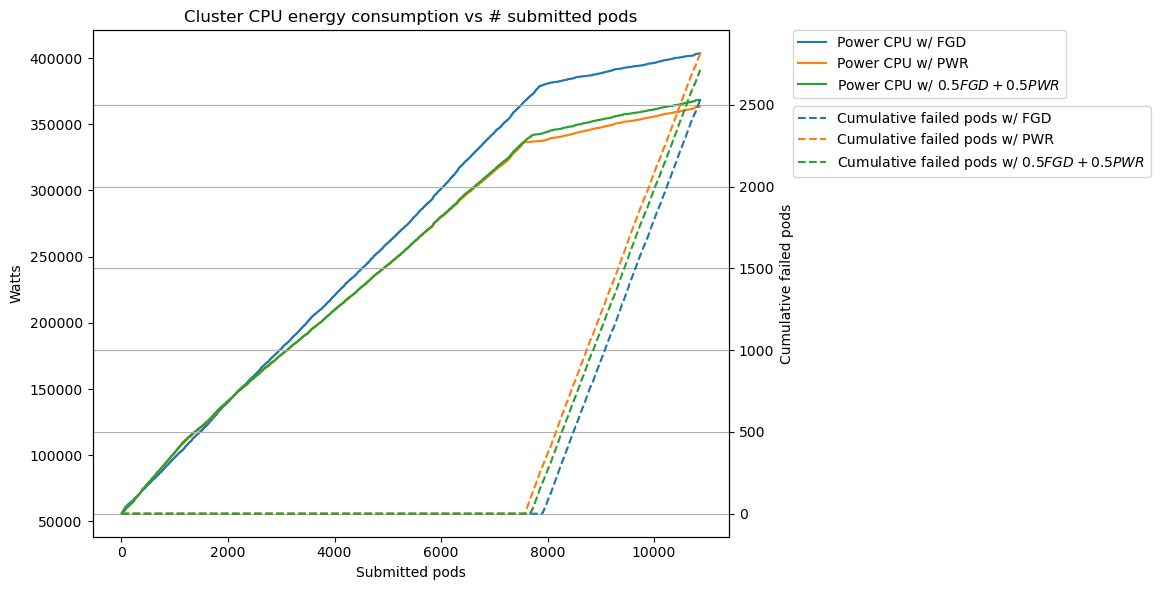

In [8]:
df_fgd = df_pwr_dict['06-FGD']
df_pwr = df_pwr_dict['07-PWR']
df_mix = df_pwr_dict['08-MIX']

df_fgd_failed = df_sched_pod_dict['06-FGD']
df_pwr_failed = df_sched_pod_dict['07-PWR']
df_mix_failed = df_sched_pod_dict['08-MIX']

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_fgd.index, df_fgd['power_cluster_CPU'], label='Power CPU w/ FGD')
ax1.plot(df_pwr.index, df_pwr['power_cluster_CPU'], label='Power CPU w/ PWR')
ax1.plot(df_mix.index, df_mix['power_cluster_CPU'], label='Power CPU w/ $0.5FGD + 0.5PWR$')
ax1.set_xlabel('Submitted pods')
ax1.set_ylabel('Watts')

ax2 = ax1.twinx()
ax2.plot(df_fgd_failed.index, df_fgd_failed["event"], label="Cumulative failed pods w/ FGD", linestyle='dashed')
ax2.plot(df_fgd_failed.index, df_pwr_failed["event"], label="Cumulative failed pods w/ PWR", linestyle='dashed')
ax2.plot(df_fgd_failed.index, df_mix_failed["event"], label="Cumulative failed pods w/ $0.5FGD + 0.5PWR$", linestyle='dashed')
ax2.set_ylabel("Cumulative failed pods")
ax2.tick_params(axis='y')

# Legends
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1), borderaxespad=0.)
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.85), borderaxespad=0.)

plt.title('Cluster CPU energy consumption vs # submitted pods')
plt.grid(True)
plt.tight_layout()
plt.show()

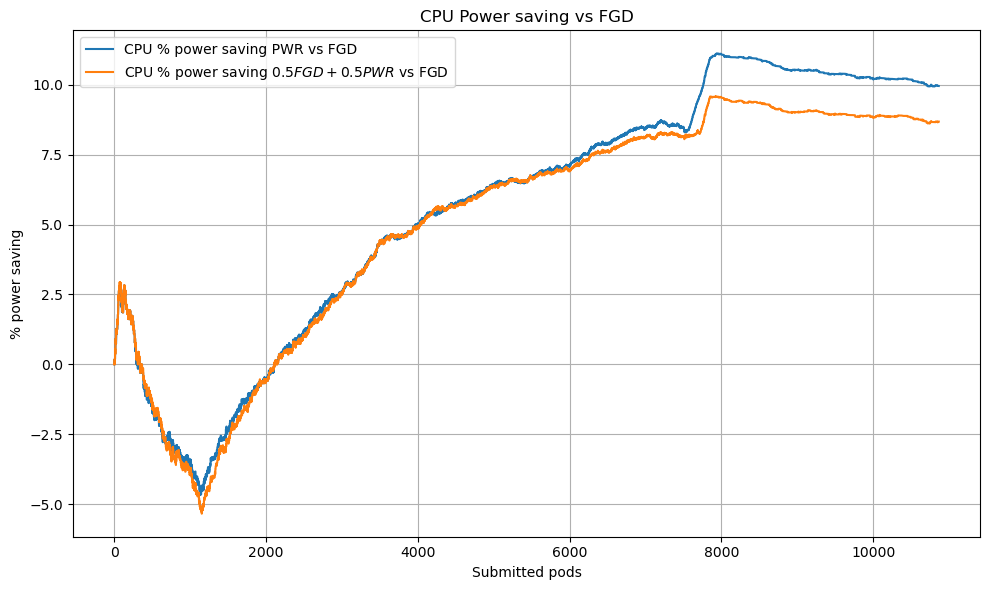

In [11]:
df_fgd = df_pwr_dict['06-FGD']
df_pwr = df_pwr_dict['07-PWR']
df_mix = df_pwr_dict['08-MIX']

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(df_pwr.index, (df_fgd['power_cluster_CPU'] - df_pwr['power_cluster_CPU']) / df_fgd['power_cluster_CPU'] * 100, label='CPU % power saving PWR vs FGD')
ax1.plot(df_mix.index, (df_fgd['power_cluster_CPU'] - df_mix['power_cluster_CPU']) / df_fgd['power_cluster_CPU'] * 100, label='CPU % power saving $0.5FGD + 0.5PWR$ vs FGD')
ax1.set_xlabel('Submitted pods')
ax1.set_ylabel('% power saving')

# Legends
ax1.legend(loc='upper left')

plt.title('CPU Power saving vs FGD')
plt.grid(True)
plt.tight_layout()
plt.show()